**Author:** Ahmadreza Attarpour  
**Email:** [a.attarpour@mail.utoronto.ca](mailto:a.attarpour@mail.utoronto.ca)  

This notebook demonstrates a CNN model for image classification using CIFAR datasets and PyTorch

---

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1.Data Preparation

The **CIFAR-10** dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. (https://www.cs.toronto.edu/~kriz/cifar.html)


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

**Data Set**  
$$X_{train} \in \mathcal{R}^{40000 \times 1024}, Y_{train} \in \mathcal{Z}^{40000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 1024}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 1024}, Y_{test} \in \mathcal{Z}^{10000}$$

In [2]:
# data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

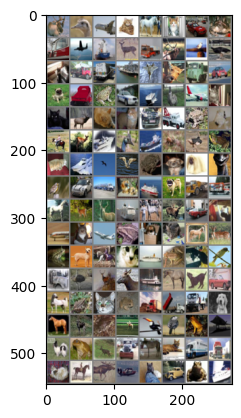

 deer  bird plane   cat horse   cat   car  frog truck plane  ship  deer truck  deer  bird  bird   cat truck truck  ship plane  deer truck   car   dog truck  frog   car  ship  bird plane   cat   cat  deer   cat   cat   car truck  frog   cat horse  deer  ship  bird  ship  deer  bird  frog   cat  ship  bird  bird  frog   dog   dog  bird  bird   car truck   dog  ship   dog truck truck horse  deer  deer  ship horse  deer   car   cat plane   cat plane  frog   dog   cat horse  deer  frog   dog horse   cat  ship  frog   cat  bird truck  bird  deer  deer  ship horse   dog   car horse  frog   cat  frog truck truck truck   dog horse  deer  frog horse  bird  bird  frog plane   dog  frog  deer truck horse   cat truck truck   cat horse  deer plane   cat   car  frog  ship


In [3]:
# visualize some images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
# print data shape and size
print(type(images), images.shape)
print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([128]) tensor([4, 2, 0, 3, 7, 3, 1, 6, 9, 0, 8, 4, 9, 4, 2, 2, 3, 9, 9, 8, 0, 4, 9, 1,
        5, 9, 6, 1, 8, 2, 0, 3, 3, 4, 3, 3, 1, 9, 6, 3, 7, 4, 8, 2, 8, 4, 2, 6,
        3, 8, 2, 2, 6, 5, 5, 2, 2, 1, 9, 5, 8, 5, 9, 9, 7, 4, 4, 8, 7, 4, 1, 3,
        0, 3, 0, 6, 5, 3, 7, 4, 6, 5, 7, 3, 8, 6, 3, 2, 9, 2, 4, 4, 8, 7, 5, 1,
        7, 6, 3, 6, 9, 9, 9, 5, 7, 4, 6, 7, 2, 2, 6, 0, 5, 6, 4, 9, 7, 3, 9, 9,
        3, 7, 4, 0, 3, 1, 6, 8])


In [5]:
# for macOS users
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

# Check if CUDA is available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("CUDA is available.")
# else:
#     device = torch.device("cpu")
#     print("CUDA not found. Using CPU.")

MPS device is available.


# 2.Model development
# CNN


In [6]:
class SimpleCNN(nn.Module):

    def __init__(self, num_in_channels, num_classes, kernel, num_filters, act_layer=nn.ReLU, dropout=0.1, batch_norm=False):

        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, stride=1, padding=kernel // 2),
            nn.BatchNorm2d(num_filters) if batch_norm else nn.Identity(),
            nn.Dropout2d(dropout),
            act_layer(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(num_filters, 2 * num_filters, kernel_size=kernel, stride=1, padding=kernel // 2),
            nn.BatchNorm2d(2 * num_filters) if batch_norm else nn.Identity(),
            nn.Dropout2d(dropout),
            act_layer(),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(2 * num_filters, 4 * num_filters, kernel_size=kernel, stride=1, padding=kernel // 2),
            nn.BatchNorm2d(4 * num_filters) if batch_norm else nn.Identity(),
            nn.Dropout2d(dropout),
            act_layer(),
        )
        self.act_layer = act_layer()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(4 * num_filters * 16 * 16, num_classes) # CIFAR-10 image size is 32x32, after 3 conv layers and 3 maxpool layers, the size becomes 4 * num_filters * 16 * 16

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


    

# 3. Experiment Design

In [7]:
def run_experiment(args):
    model = SimpleCNN(args.num_in_channels, args.num_classes, args.kernel, args.num_filters, args.act_layer, args.dropout, args.batch_norm)
    print(model)

    # GPU
    model.to(device)

    # ====== Loss function ====== #
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    best_val_loss = float('inf')
    best_epoch = 0

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        
        # train_loader contains 128 * 1 * 28 * 28 boxes
        train_loss = 0
        step = 0
        for input_x, true_y in tqdm(train_loader):

            step += 1
            optimizer.zero_grad()

            input_x = input_x.to(device)
            true_y = true_y.to(device)

            pred_y = model(input_x)

            loss = criterion(pred_y.squeeze(), true_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # print loss for each step
            #tqdm.write(f"Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")


        # calculate the train loss for this epoch
        train_loss = train_loss / len(train_loader)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)

        # print average loss for the epoch
        tqdm.write(f"Epoch {epoch+1}/{args.epoch}, Average Training Loss: {train_loss:.4f}")

        # ====== Validation ====== #

        if epoch % args.val_interval == 0:
            model.eval() # Set the model be 'val mode' 
            val_loss = 0

            with torch.no_grad():
                for input_x, true_y in tqdm(val_loader):

                    input_x = input_x.to(device)
                    true_y = true_y.to(device)

                    pred_y = model(input_x)

                    loss = criterion(pred_y.squeeze(), true_y)

                    val_loss += loss.item()

                val_loss = val_loss / len(val_loader)
                list_val_loss.append(val_loss)

                # print average loss for the epoch
                tqdm.write(f"Validation Loss: {val_loss:.4f}")

                # Save the model if the validation loss is the best so far
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    best_model = model
                    tqdm.write(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")

    return list_epoch, list_train_loss, list_val_loss, best_model
        



# 4. Train & Evaluation

In [8]:
ts = time.time()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()

args = parser.parse_args("")
args.num_in_channels = 3 # CIFAR10 has 3 channels
args.num_classes = 10 # number of classes 
args.kernel = 3
args.num_filters = 64
args.act_layer = nn.ReLU
args.dropout = 0.1
args.batch_norm = True
args.val_interval = 1

args.lr = 0.005
args.epoch = 25

list_epoch, list_train_loss, list_val_loss, best_model = run_experiment(args)

te = time.time()

print('Elapsed time: {} sec'.format(int(te-ts)))

SimpleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): ReLU()
  )
  (act_layer): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)


100%|██████████| 313/313 [01:03<00:00,  4.90it/s]


Epoch 1/25, Average Training Loss: 10.6200


100%|██████████| 79/79 [00:04<00:00, 16.58it/s]


Validation Loss: 1.6295
Best model saved at epoch 1 with validation loss: 1.6295


100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Epoch 2/25, Average Training Loss: 1.4914


100%|██████████| 79/79 [00:03<00:00, 21.02it/s]


Validation Loss: 1.2836
Best model saved at epoch 2 with validation loss: 1.2836


100%|██████████| 313/313 [01:24<00:00,  3.71it/s]


Epoch 3/25, Average Training Loss: 1.2844


100%|██████████| 79/79 [00:03<00:00, 19.92it/s]


Validation Loss: 1.1437
Best model saved at epoch 3 with validation loss: 1.1437


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Epoch 4/25, Average Training Loss: 1.1589


100%|██████████| 79/79 [00:03<00:00, 19.99it/s]


Validation Loss: 1.0663
Best model saved at epoch 4 with validation loss: 1.0663


100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 5/25, Average Training Loss: 1.0464


100%|██████████| 79/79 [00:03<00:00, 20.96it/s]


Validation Loss: 0.9598
Best model saved at epoch 5 with validation loss: 0.9598


100%|██████████| 313/313 [01:40<00:00,  3.10it/s]


Epoch 6/25, Average Training Loss: 0.9521


100%|██████████| 79/79 [00:03<00:00, 20.42it/s]


Validation Loss: 0.9190
Best model saved at epoch 6 with validation loss: 0.9190


100%|██████████| 313/313 [01:44<00:00,  3.00it/s]


Epoch 7/25, Average Training Loss: 0.8663


100%|██████████| 79/79 [00:03<00:00, 21.65it/s]


Validation Loss: 0.8666
Best model saved at epoch 7 with validation loss: 0.8666


100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Epoch 8/25, Average Training Loss: 0.8038


100%|██████████| 79/79 [00:03<00:00, 21.80it/s]


Validation Loss: 0.8821


100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Epoch 9/25, Average Training Loss: 0.7112


100%|██████████| 79/79 [00:03<00:00, 20.40it/s]


Validation Loss: 0.8840


100%|██████████| 313/313 [01:44<00:00,  2.99it/s]


Epoch 10/25, Average Training Loss: 0.6451


100%|██████████| 79/79 [00:03<00:00, 21.33it/s]


Validation Loss: 0.8854


100%|██████████| 313/313 [01:42<00:00,  3.06it/s]


Epoch 11/25, Average Training Loss: 0.5732


100%|██████████| 79/79 [00:03<00:00, 21.34it/s]


Validation Loss: 0.9299


100%|██████████| 313/313 [01:37<00:00,  3.22it/s]


Epoch 12/25, Average Training Loss: 0.4983


100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Validation Loss: 0.8866


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch 13/25, Average Training Loss: 0.4408


100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


Validation Loss: 0.9307


100%|██████████| 313/313 [01:36<00:00,  3.26it/s]


Epoch 14/25, Average Training Loss: 0.3781


100%|██████████| 79/79 [00:03<00:00, 21.15it/s]


Validation Loss: 1.0362


100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch 15/25, Average Training Loss: 0.3356


100%|██████████| 79/79 [00:03<00:00, 21.53it/s]


Validation Loss: 1.0622


100%|██████████| 313/313 [01:30<00:00,  3.46it/s]


Epoch 16/25, Average Training Loss: 0.3012


100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Validation Loss: 1.1681


100%|██████████| 313/313 [01:27<00:00,  3.58it/s]


Epoch 17/25, Average Training Loss: 0.2608


100%|██████████| 79/79 [00:03<00:00, 21.69it/s]


Validation Loss: 1.1739


100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 18/25, Average Training Loss: 0.2265


100%|██████████| 79/79 [00:03<00:00, 19.92it/s]


Validation Loss: 1.2486


100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epoch 19/25, Average Training Loss: 0.2165


100%|██████████| 79/79 [00:04<00:00, 19.71it/s]


Validation Loss: 1.2263


100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


Epoch 20/25, Average Training Loss: 0.1974


100%|██████████| 79/79 [00:03<00:00, 21.31it/s]


Validation Loss: 1.3217


100%|██████████| 313/313 [01:30<00:00,  3.44it/s]


Epoch 21/25, Average Training Loss: 0.1771


100%|██████████| 79/79 [00:03<00:00, 21.71it/s]


Validation Loss: 1.4977


100%|██████████| 313/313 [01:28<00:00,  3.52it/s]


Epoch 22/25, Average Training Loss: 0.1806


100%|██████████| 79/79 [00:03<00:00, 21.46it/s]


Validation Loss: 1.4645


100%|██████████| 313/313 [01:29<00:00,  3.48it/s]


Epoch 23/25, Average Training Loss: 0.1635


100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


Validation Loss: 1.4929


100%|██████████| 313/313 [02:55<00:00,  1.79it/s]


Epoch 24/25, Average Training Loss: 0.1524


100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


Validation Loss: 1.6552


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


Epoch 25/25, Average Training Loss: 0.1474


100%|██████████| 79/79 [00:06<00:00, 11.49it/s]

Validation Loss: 1.5888
Elapsed time: 2686 sec


# 5. Report and test

Text(0.5, 1.0, 'epoch vs loss')

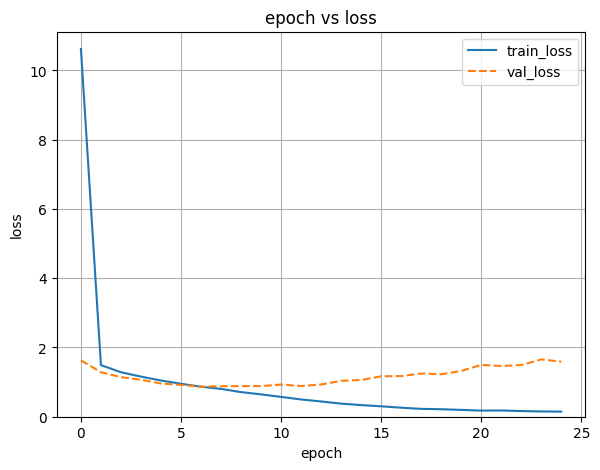

In [9]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, max(list_train_loss) + 0.5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# 6. Test

Accuracy: 0.6250


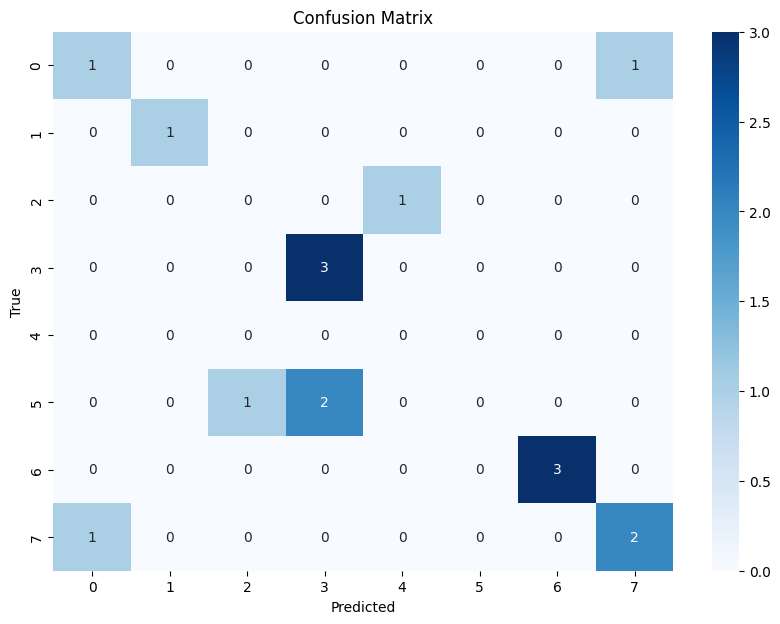

In [10]:
# test the best model on test

best_model.eval() # Set the model be 'test mode'


all_true_ys = []
all_pred_ys = []

# ====== Test ====== #
with torch.no_grad():

    for input_x, true_y in test_loader:

        input_x = input_x.to(device)
        true_y = true_y.to(device)

        pred_y = best_model(input_x)

        pred_y = torch.argmax(pred_y, dim=1)
        pred_y = pred_y.cpu().numpy()
        true_y = true_y.cpu().numpy()

        # get all the true and predicted labels
        all_true_ys.extend(y for y in true_y)
        all_pred_ys.extend(y for y in pred_y)


    accuracy = accuracy_score(true_y, pred_y)
    print(f"Accuracy: {accuracy:.4f}")

    # plot the confusion matrix
    cm = confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
